# Pore Distribution
Compares the count and size of predicted and target pores.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from scipy import integrate, ndimage, stats

In [2]:
# Load Split Indexes
train_indexes = np.load("./train_indexes.npy")
test_indexes = np.load("./test_indexes.npy")

train_length = len(train_indexes)
test_length = len(test_indexes)

print(f"train_indexes ({len(train_indexes)}): {train_indexes}")
print(f"test_indexes ({len(test_indexes)}): {test_indexes}")

train_indexes (120): [123  89 103  10 157   2 158 121  72 109  19  65  91  66  33  25 102  64
  59 118 141  60   7  14  70  79 130  53 115 122  96  63  97 136  36 135
  42  56  15  27 129  93 107  24   4  31  40  95  18 144  67  92 119 154
  78  84  62  87 142   6  76 146  51 155 124 156 143  20  61 101 106 131
  43  90 153  44 127 151  45  21  46 140  16 149 108 152 120  11 125  13
  28  82  86  69  88  39 132 114 150  98  54  30 134 116   9   8  37  38
 111 139  81  71  57  50  26  49   1  75  41 105]
test_indexes (39): [148  58  55  22 110  68 147 100  34  32 133  48  80  52  94   5 126 117
  73  83  17 104 113  29  85 138  99  12 128  74   0 112  35  77  23 137
  47   3 145]


In [3]:
files = os.listdir("predictions")

EPOCHS = []
for file in files:
  EPOCHS.append(int(file.split(".p")[0]))

EPOCHS = np.sort(EPOCHS)
print(EPOCHS)

[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000]


In [9]:
if not os.path.isdir("pore_distribution"):
  os.mkdir("pore_distribution")

with open(f"./targets.p", "rb") as targets_file:
  targets = pickle.load(targets_file)

epochs_wasserstein = []
  
epochs_wasserstein_min = []
epochs_wasserstein_mean = []
epochs_wasserstein_max = []

epochs = []

for epoch in EPOCHS:
  
  if not os.path.isdir(f"pore_distribution/{epoch}"):
    os.mkdir(f"pore_distribution/{epoch}")

  build_layers_wasserstein = []
  for index in range(test_length):
    predictions = []

    with open(f"./predictions/{epoch}.p", "rb") as predictions_file:
      predictions = pickle.load(predictions_file)

    prediction = predictions[index].squeeze()
    prediction_pore_labels, prediction_pore_count = ndimage.label(prediction)
    prediction_pore_labels_non_zero = prediction_pore_labels[prediction_pore_labels != 0]
    prediction_pore_id, prediction_pore_size = np.unique(
      prediction_pore_labels_non_zero, return_counts=True
    )

    target = targets[index].squeeze()
    target_pore_labels, target_pore_count = ndimage.label(target)
    target_pore_labels_non_zero = target_pore_labels[target_pore_labels != 0]
    target_pore_id, target_pore_size = np.unique(target_pore_labels_non_zero, return_counts=True)

    # Accounts for empty distributions
    if (len(prediction_pore_size)):
      wasserstein_dist = stats.wasserstein_distance(prediction_pore_size, target_pore_size)
      build_layers_wasserstein.append(wasserstein_dist)

  if (len(build_layers_wasserstein)):
    epochs.append(epoch)
    epochs_wasserstein.append(build_layers_wasserstein)
    epochs_wasserstein_min.append(np.min(build_layers_wasserstein))
    epochs_wasserstein_mean.append(np.mean(build_layers_wasserstein))
    epochs_wasserstein_max.append(np.max(build_layers_wasserstein))



In [13]:
print(f"Wasserstein Distance -> Min: {epochs_wasserstein_min[-1]:.3f}, Mean: {epochs_wasserstein_mean[-1]:.3f}, Max: {epochs_wasserstein_max[-1]:.3f}")

Wasserstein Distance -> Min: 2.565, Mean: 14.186, Max: 36.468


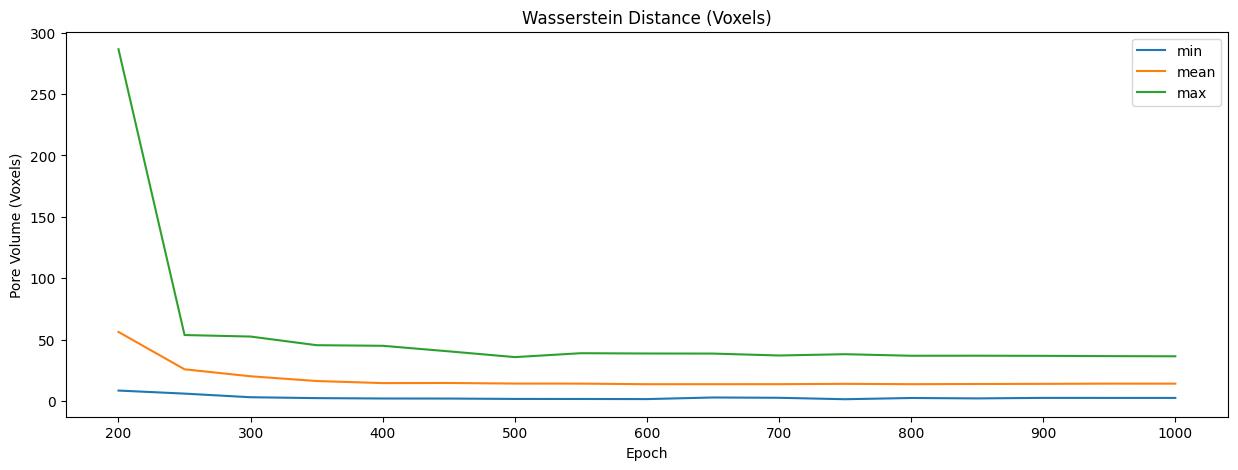

In [12]:
sorted_test_indexes = sorted(test_indexes)

plt.figure(figsize=(15, 5))
plt.plot(epochs, epochs_wasserstein_min, label="min")
plt.plot(epochs, epochs_wasserstein_mean, label="mean")
plt.plot(epochs, epochs_wasserstein_max, label="max")

# Add labels and title
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Pore Volume (Voxels)')
plt.title(f"Wasserstein Distance (Voxels)")

# Show the plot
# plt.savefig(f"wasserstein_trend/test.png")
plt.show()